In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import os
path = '/content/drive/MyDrive/Major Project/data/central_data'
os.chdir(path)

In [10]:
df  = pd.read_csv('cleaned.csv', parse_dates=[0])
df.head()

,Day,public_information_campaigns,stay_home_requirements,close_public_transport,cancel_public_events,testing_policy,stringency_index,vaccination_policy,facial_coverings,total_vaccinations,people_vaccinated,people_fully_vaccinated,mobility_driving,mobility_walking,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.35,-0.82,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.96,4.08,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.77,7.41,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.64,13.91,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
temp = df.copy()
places = ['close_public_transport','retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces']

places.remove('residential')
temp.drop(columns=places, inplace = True)

temp['avg_mobility'] = (temp['mobility_walking'] + temp['mobility_driving'])/2
temp.drop(columns = ['mobility_walking', 'mobility_driving'], inplace = True)
temp.head()


,Day,public_information_campaigns,stay_home_requirements,cancel_public_events,testing_policy,stringency_index,vaccination_policy,facial_coverings,total_vaccinations,people_vaccinated,people_fully_vaccinated,residential,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,avg_mobility
0,2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.019121,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.019121,0.0,0.0,0.0,0.0,0.0,0.0,0.765
2,2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.019121,0.0,0.0,0.0,0.0,0.0,0.0,6.020
3,2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.019121,0.0,0.0,0.0,0.0,0.0,0.0,9.090
4,2020-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.019121,0.0,0.0,0.0,0.0,0.0,0.0,17.275


In [12]:
!pip install hmmlearn

     |████████████████████████████████| 378kB 6.5MB/s 


In [19]:
import matplotlib as mpl
from cycler import cycler
from itertools import product
mpl.rcParams['axes.prop_cycle'] = cycler( color = ['lightblue', 'cyan', 'lightgreen', 'lightyellow', 'orange', 'red'])   # default bgrcmyk
from math import log
from tqdm import tqdm
from datetime import timedelta
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

# edit these to select features
features = ['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']

def train_test_split(df, test_size):
    traindf = df[:-test_size]
    testdf = df[-test_size:].reset_index(drop = True)
    return traindf, testdf

# numSteps_dc * numSteps_dr * numSteps_st possible outcomes ;_;
def compute_all_possible_outcomes( numSteps_dc=16, numSteps_dr=16, numSteps_st = 10):
    frac_dc_range = np.linspace(-1, 1, numSteps_dc)
    frac_dr_range = np.linspace(-1, 1, numSteps_dr)
    # frac_st_range = np.linspace(0, 1, numSteps_st)
    frac_st_range = [0, 1, 2, 3]
    return np.array (list (product ( frac_dc_range, frac_dr_range, frac_st_range )))

def AIC( likelihood, numParams):
    return ( -2 * log(abs(likelihood)) + 2*numParams )

def BIC( likelihood, numParams, numObs):
    return ( -2 * log(abs(likelihood)) + numParams * log(numObs) )

def select(arr):
    total = sum(arr)
    probs = [i/total for i in arr]
    selected = np.random.choice(arr, p = probs)
    return arr.index(selected)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

class HMMPredictor():
    def __init__( self, numHiddenStates, latency_days, outcomes, random_state = 1 ):
        self.model = None
        self.numHiddenStates = numHiddenStates
        self.latency_days = latency_days
        self.possible_outcomes = outcomes
        np.random.seed(random_state)

    @staticmethod
    def extract_features( df ):
        # dc = np.array( df['Daily Confirmed'] )
        # dr = np.array( df['Daily Recovered'] )
        # st = np.array( df['stringency_index'] )

        # #x(t) = ( x(t) - x(t-1) ) / x(t-1)
        # frac_dc = np.diff(dc, prepend=0 ) / np.insert(dc[:-1], 0, 0)
        # frac_dr = np.diff(dr, prepend=0 ) / np.insert(dr[:-1], 0, 0)

        # features = np.column_stack( (frac_dc, frac_dr, st ))
        # features = np.nan_to_num(features, neginf = -1, posinf = 1)
        
        return df[features].to_numpy()

    # predicts the most likely outcome (observation) after observing data
    def get_most_probable_outcome( self, data ):
        previous_data_features = HMMPredictor.extract_features( data )
        
        # # # exploring all possible outcomes for a day (Brute Force) used with frac_change features
        # # # and selecting the most likely - Works Great but for Wrong Reasons !

        # outcome_score = []  #likelihoods for each possible outcome
        # states = [] # corresponding hidden state
        # for possible_outcome in self.possible_outcomes:
        #     total_data = np.vstack(( previous_data_features, possible_outcome ))
        #     outcome_score.append( self.model.score(total_data) )
        #     outcome_state = self.model.predict(total_data)
        #     # print(outcome_score[-1])
        #     states.append(outcome_state[-1])    # state corresponding to last observeration
        
        # # mle_index = select(outcome_score)
        # mle_index = np.argmax(outcome_score)
        # most_probable_outcome = self.possible_outcomes[ mle_index ].reshape((1,-1))
        # most_probable_state = states[ mle_index ]

        # Or computing the next likely outcome
        last_state = self.model.predict(previous_data_features)[-1]
        transmat = self.model.transmat_[last_state]
        # next_state = np.argmax(transmat[last_state])
        next_state = np.where( transmat == np.random.choice( transmat, p = transmat ))[0][0]
        most_probable_state = next_state
        mu = self.model.means_[next_state]
        sigma = self.model.covars_[next_state]
        most_probable_outcome = np.empty((1, mu.shape[0]))
        for i in range(mu.shape[0]):
            most_probable_outcome[0,i] = np.random.normal(mu[i], sigma[i][i], 1)

        return most_probable_outcome, most_probable_state

    # predicts the outcome for day_index given data for [ day_index-latency_days , day_index )
    def predict_for_1_day (self, day_index , data ) :
        history_start_index = max(0, day_index - self.latency_days)
        history = data[ history_start_index:day_index ]

        predicted_outcome, predicted_state = self.get_most_probable_outcome( history )

        # prev_day_index = max(0, day_index-1)
        # prev_day_values = data.iloc[prev_day_index].to_numpy().reshape(1,-1)
        # assert predicted_outcome.shape == prev_day_values.shape, f'{predicted_outcome.shape} ,{prev_day_values.shape}'

        curr_day_values = predicted_outcome

        # # # compute actual value from rate of change
        # curr_day_values[0,0] = prev_day_values[0,0] * (1 + predicted_outcome[0,0])
        # curr_day_values[0,1] = prev_day_values[0,1] * (1 + predicted_outcome[0,1])

        return curr_day_values, predicted_state
    
    # predicts the values for n_days starting with the day_index observation in data
    def predict_for_n_days(self, n_days, day_index, data):

        predictions = np.zeros((n_days, len(features)))
        states = np.zeros((n_days))
        runs = 20
        for _ in range( runs ):
            for day in range(n_days):
                pred , state = self.predict_for_1_day( day_index+day, data)
                predictions[day] += pred.reshape(-1)
                states[day] += state

        return (predictions / runs), (states / runs).astype('int')
    
    # predicting successive days using predictions of previous days
    def forecast_n_days(self, n_days, historydf):
        day_index = 0
        assert historydf.empty == False, f'historydf should contain atleast 1 entry'
        day_index += len(historydf.index)
        states = []

        for day in range(n_days):
            pred , state = self.predict_for_1_day( day_index + day, historydf )
            historydf = historydf.append( pd.DataFrame(pred, columns = historydf.columns), ignore_index = True)
            states.append( state )
            print(f'progress: {day+1}/{n_days}, prediction = {pred}')

        return historydf, states
    
    def plot_predictions(self, preds, states, start_date, true_y = None, plot_states = False):
        n =  preds.shape[1]
        n_days = preds.shape[0]
        fig, axes = plt.subplots( n , 1, figsize=(16, 5*n))
        day_indices = [ start_date + timedelta(day) for day in range(n_days) ]

        for i in range(n):
            axes[i].set_title(features[i])
            axes[i].plot(day_indices, preds[:,i], 'darkgreen', label = 'predicted')
            if true_y is not None:
                axes[i].plot(day_indices, true_y[features[i]][:n_days], 'blue', label = 'actual' )

            if plot_states:
                for j, state in enumerate( states ):
                    axes[i].axvspan( start_date + timedelta(j), start_date + timedelta(j+1), facecolor = f'C{int(state)}')
            
            axes[i].legend()
        plt.show()

    def fit_model( self , traindf):
        self.model = GaussianHMM( n_components = self.numHiddenStates, n_iter = 100, covariance_type='full', algorithm='viterbi', random_state = 42 )
        train_feats = HMMPredictor.extract_features( traindf )
        self.model.fit( train_feats  )
        aic = AIC( self.model.score(train_feats), self.numHiddenStates * 2 * train_feats.shape[1] )
        bic = BIC( self.model.score(train_feats), self.numHiddenStates * 2 * train_feats.shape[1], train_feats.shape[0] )
        print(f'{self.model.monitor_}\nConverged = {self.model.monitor_.converged}\nAIC:{aic}\nBIC:{bic}')
        return {'HMM' : self.model, 'AIC':aic , 'BIC': bic}


In [20]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
data = temp[ features ]
scalers = {}
scaled_data = pd.DataFrame()
for i,col in enumerate(features):
    scaler = MinMaxScaler((0,1))
    scaled_data[col] = scaler.fit_transform(data[col].to_numpy().reshape(-1,1)).reshape(-1)
    scalers[col] = scaler

start_date = temp['Day'][0]
test_size = 56
latency_days = 14
numHiddenStates = 6
X,y = train_test_split( scaled_data, test_size)

predictor = HMMPredictor( numHiddenStates, latency_days, compute_all_possible_outcomes() )
model_dict = predictor.fit_model(X)

ConvergenceMonitor(
    history=[1031.1456520761656, 1684.3529789190234, 2056.2724335084367, 2319.8257226131673, 2498.8102661963967, 2798.1333047870594, 2842.443375253576, 2858.3240472635957, 2863.391744995664, 2865.7121437301394, 2867.289297601976, 2867.6641217016895, 2869.0525955672083, 2880.13977397176, 2892.7427248012027, 2913.3934627533026, 2915.582332153722, 2915.550433540899],
    iter=18,
    n_iter=100,
    tol=0.01,
    verbose=False,
)
Converged = True
AIC:56.04434452654114
BIC:199.7370682224285


## Test Set Predictions

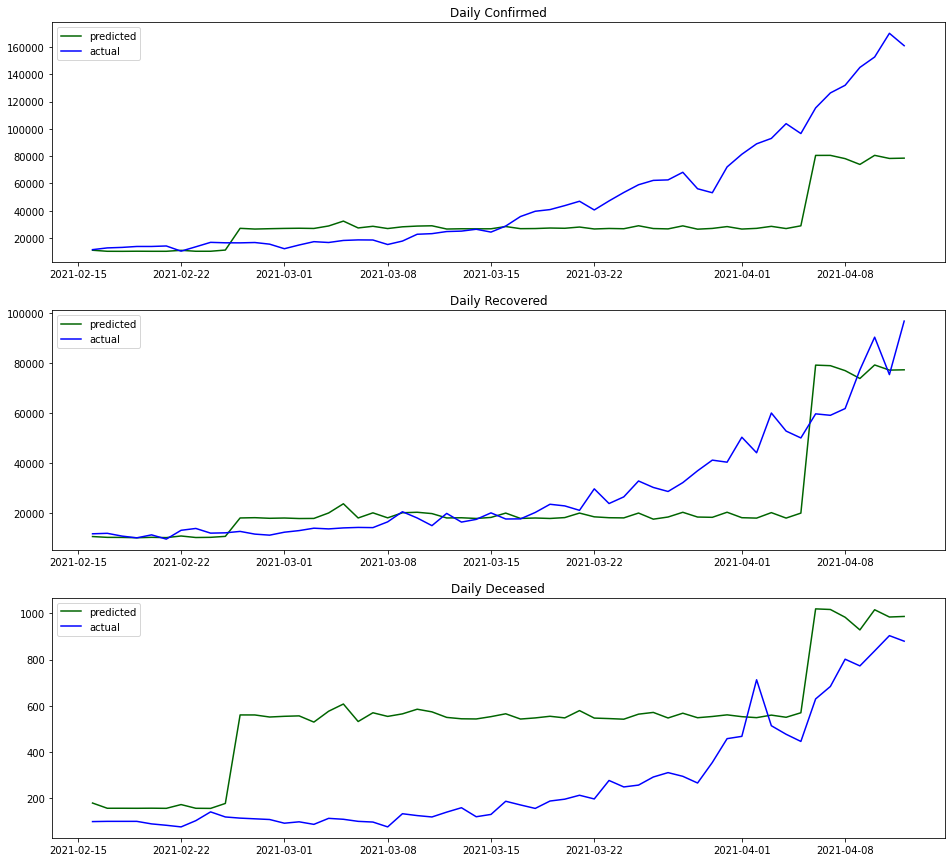

In [24]:
outsample_preds, outsample_states = predictor.predict_for_n_days( 56, len(data.index)-56 , scaled_data )
outsample_preds_descaled = np.zeros_like(outsample_preds)
for i,col in enumerate(features):
    outsample_preds_descaled[:,i] = scalers[col].inverse_transform(outsample_preds[:,i].reshape(-1,1)).reshape(-1)
predictor.plot_predictions(outsample_preds_descaled, outsample_states, start_date + timedelta(len(data.index)-56), data[-56:].reset_index(drop = True))

## Train Set Predictions

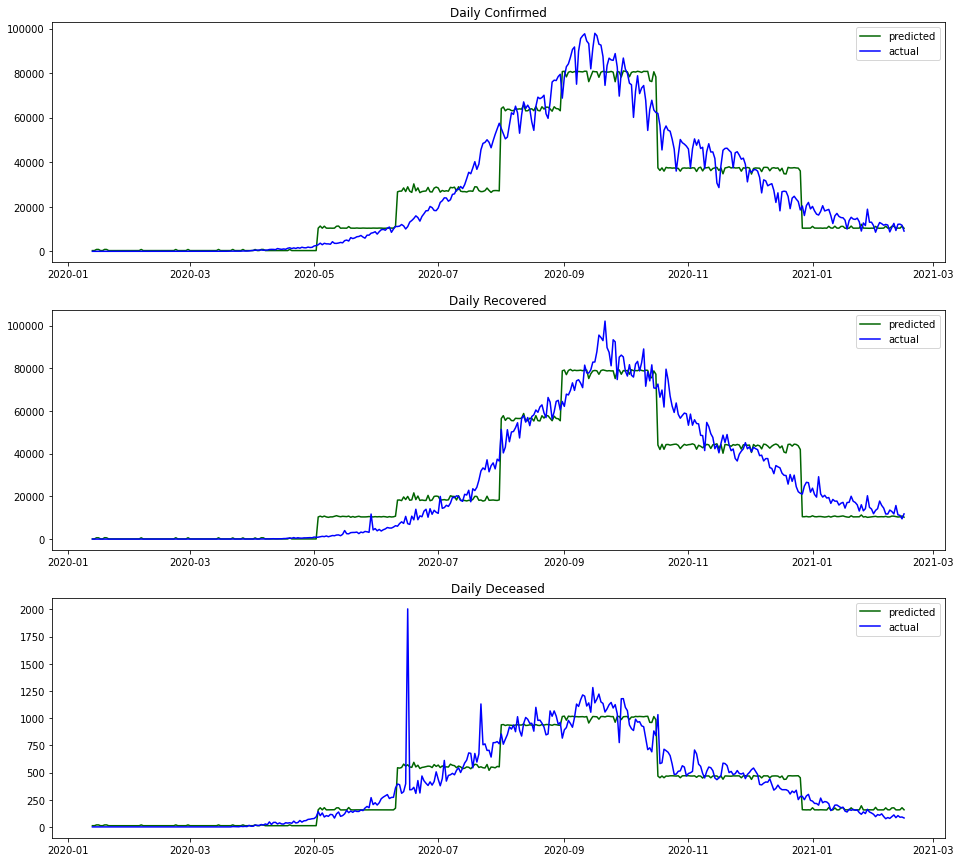

In [38]:
insample_preds, insample_states = predictor.predict_for_n_days( 400, 1 , scaled_data )
insample_preds_descaled = np.zeros_like(insample_preds)
for i,col in enumerate(features):
    insample_preds_descaled[:,i] = scalers[col].inverse_transform(insample_preds[:,i].reshape(-1,1)).reshape(-1)
predictor.plot_predictions(insample_preds_descaled, insample_states, start_date, data[:400] )

## Test Set Forecasting

progress: 1/30, prediction = [[0.4304137  0.68886918 0.78467734]]
progress: 2/30, prediction = [[0.43714126 0.70743454 0.7834283 ]]
progress: 3/30, prediction = [[0.44822088 0.65684551 0.78341673]]
progress: 4/30, prediction = [[0.44250914 0.70554262 0.7838239 ]]
progress: 5/30, prediction = [[0.44227691 0.65980654 0.784465  ]]
progress: 6/30, prediction = [[0.44100534 0.67390868 0.78289518]]
progress: 7/30, prediction = [[0.4327722  0.6952754  0.78369578]]
progress: 8/30, prediction = [[0.43192781 0.67754121 0.78235399]]
progress: 9/30, prediction = [[0.43644394 0.66865267 0.78223016]]
progress: 10/30, prediction = [[0.43627498 0.66434843 0.78306719]]
progress: 11/30, prediction = [[0.44324654 0.66440957 0.78288532]]
progress: 12/30, prediction = [[0.44282842 0.6689182  0.78300838]]
progress: 13/30, prediction = [[0.44131665 0.66265641 0.78236498]]
progress: 14/30, prediction = [[0.4465938  0.66602148 0.7827703 ]]
progress: 15/30, prediction = [[0.43689296 0.7185014  0.78422117]]
prog

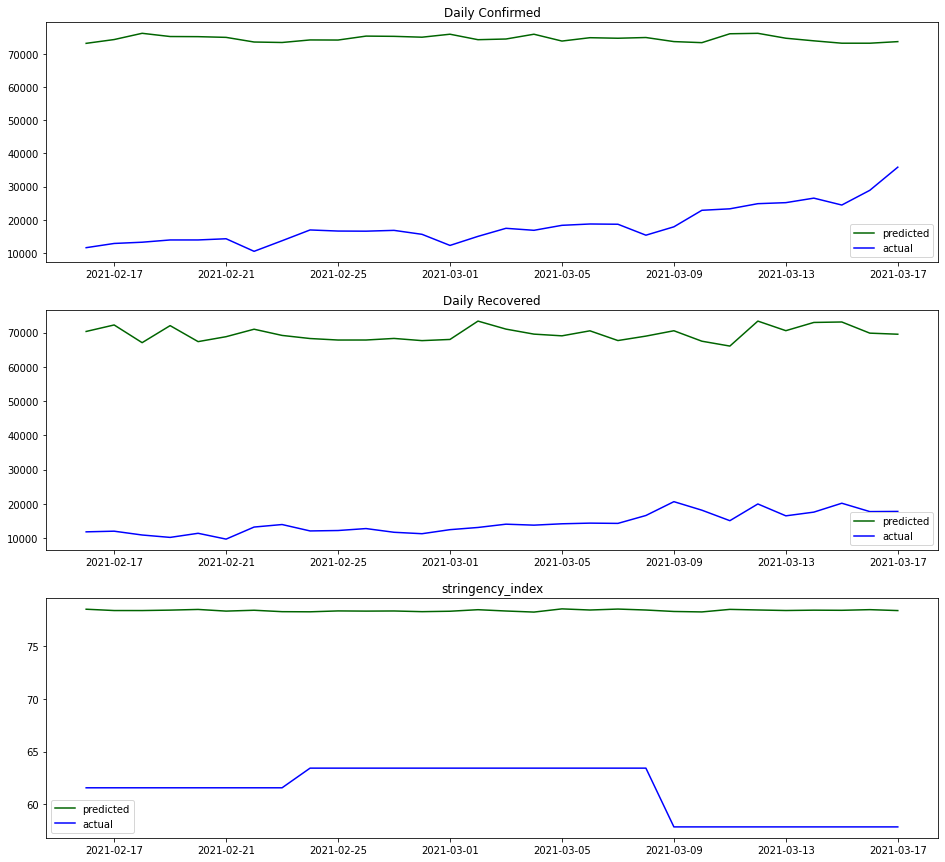

In [19]:
num_days = 30

forecasted_df, forecasted_states = predictor.forecast_n_days( num_days, scaled_data[400-14:] )  #-14 for hitory
forecasted_preds = forecasted_df.to_numpy()[-num_days:]
forecasted_preds_descaled = np.zeros_like(forecasted_preds)
for i,col in enumerate(features):
    forecasted_preds_descaled[:,i] = scalers[col].inverse_transform(forecasted_preds[:,i].reshape(-1,1)).reshape(-1)
predictor.plot_predictions(forecasted_preds_descaled, forecasted_states, start_date + timedelta(400), true_y = data[400:].reset_index(drop = True))

# Latency Day Analysis

In [20]:
lag_days = [ 1, 7, 10, 14]
hidden_states = [3, 4, 6, 10, 20]
pred_dict = {}
for l in lag_days:
    for hs in hidden_states:
        p = HMMPredictor(hs, l, None)
        p.fit_model(X)
        pred_dict[(l, hs)] = p.predict_for_n_days( 56, len(data.index)-56 , scaled_data )

ConvergenceMonitor(
    history=[568.568825073216, 1339.0914441776388, 1811.8009039295662, 2220.055744442409, 2226.9028975781034, 2234.1171998414634, 2244.5075589355424, 2248.2778678482055, 2248.722488383073, 2248.877881465341, 2248.9489919927623, 2248.9856134505153, 2249.0055482373277, 2249.0167112077415, 2249.0230586068174],
    iter=15,
    n_iter=100,
    tol=0.01,
    verbose=False,
)
Converged = True
AIC:20.563494353427387
BIC:92.40985620137106
ConvergenceMonitor(
    history=[574.7023685402434, 1370.9359310747145, 1873.6982989059998, 2358.199798406482, 2442.54639592141, 2456.5289692171823, 2462.490455288221, 2468.0663481188567, 2475.5757298795647, 2476.697526061089, 2476.7357201988066, 2476.739157072722],
    iter=12,
    n_iter=100,
    tol=0.01,
    verbose=False,
)
Converged = True
AIC:32.370601034816474
BIC:128.16575016540804
ConvergenceMonitor(
    history=[578.1308885814857, 1417.3260558885574, 1954.212893771336, 2419.0102002679405, 2614.5165343627764, 2717.2800166445977, 

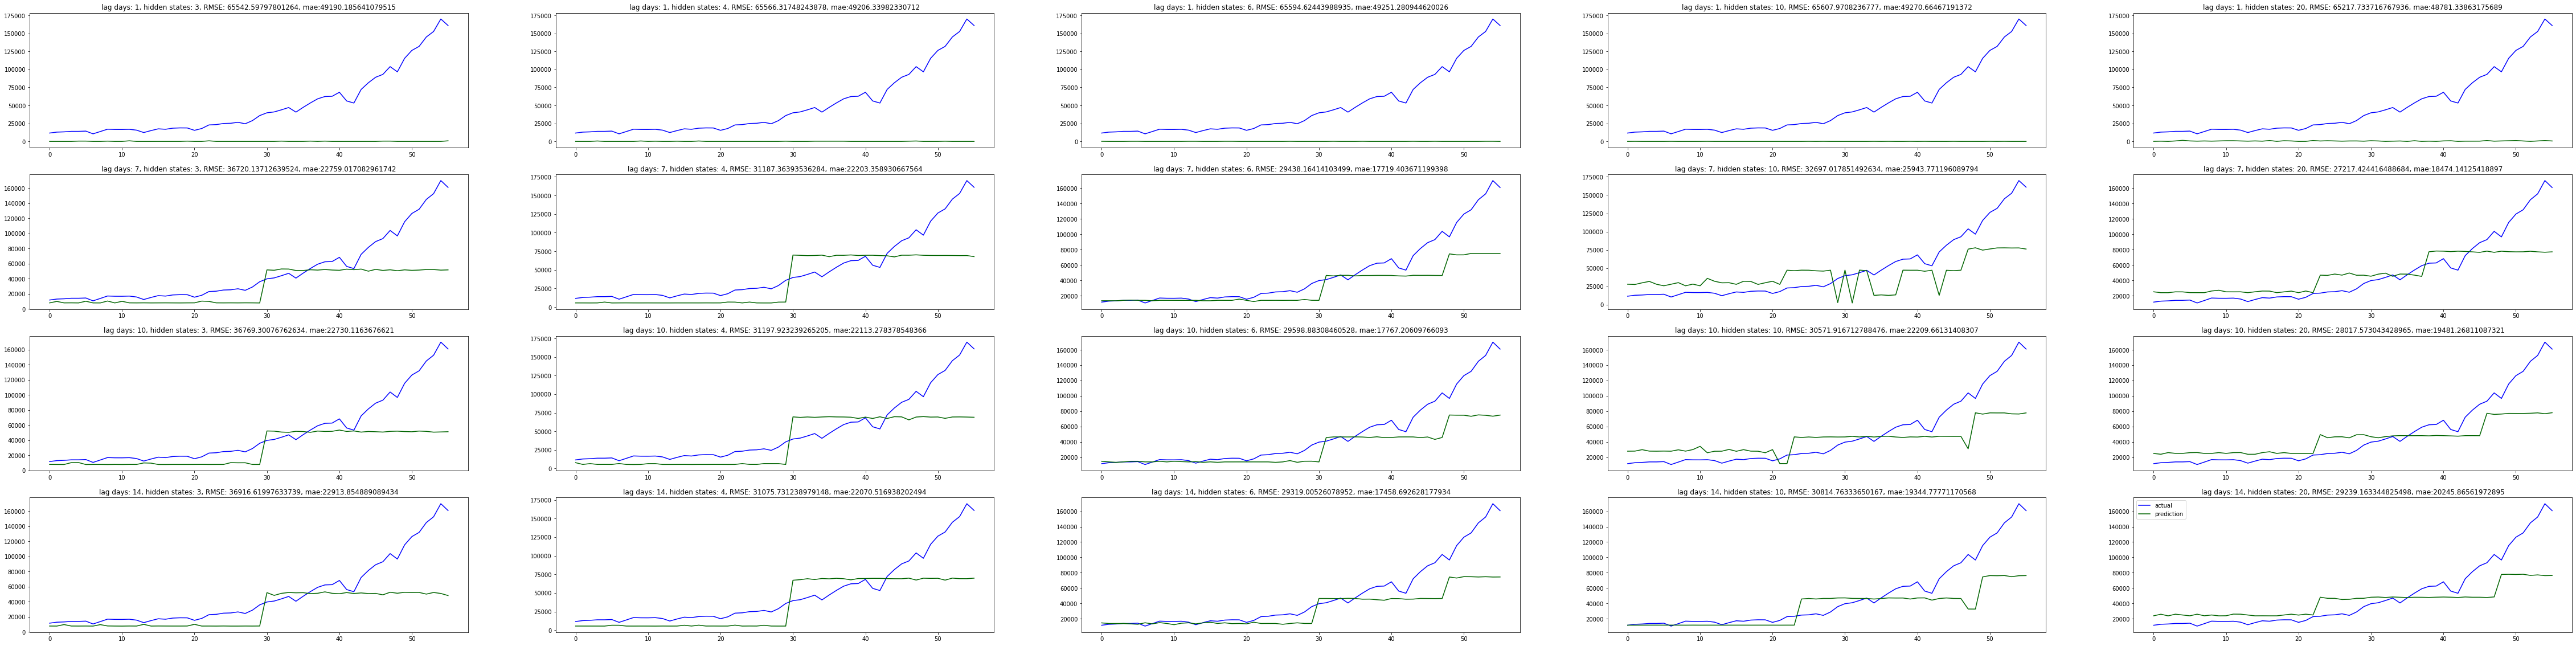

In [27]:
fig, axes = plt.subplots( 4 , 5, figsize=(5*16, 5*4))
for i, l in enumerate(lag_days):
    for j, h in enumerate(hidden_states):
        preds = np.empty_like(pred_dict[(l,h)][0])
        preds[:,0] = scalers['Daily Confirmed'].inverse_transform(pred_dict[(l,h)][0][:,0].reshape(-1,1)).reshape(-1)
        axes[i,j].plot(data[400:]['Daily Confirmed'].reset_index(drop = True), color = 'blue', label = 'actual')
        axes[i,j].plot(preds[:,0], color = 'darkgreen', label = 'prediction')
        rmse = mean_squared_error( data[400:]['Daily Confirmed'].reset_index(drop = True) , preds[:,0], squared = False )
        mae = mean_absolute_error(data[400:]['Daily Confirmed'].reset_index(drop = True) , preds[:,0])
        axes[i,j].set_title(f'lag days: {l}, hidden states: {h}, RMSE: {rmse }, mae:{mae}')
plt.legend()
plt.show()